In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from influence.closed_forms import I_loss_RidgeCf
from models.regularized_regression import RegularizedRegression
from models.hyperplane_clf import BinaryLogisticRegression

/Users/zed/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.BinaryMNIST17, test_config=[0])
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)


scl_x = StandardScaler()
scl_y = StandardScaler()
X_train = scl_x.fit_transform(X_train)
#X_test = scl_x.transform(X_test)



init_eta = 1e-1
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = None

if hasattr(test_indices, '__iter__') and hasattr(leave_indices, '__iter__'):
    assert not set(test_indices) & set(leave_indices)
    print(test_indices)
    print(leave_indices)

X_train shape: (9084, 784)
y_train shape: (9084, 1)
X_test shape: (1, 784)
y_test shape: (1, 1)
9084 784


/Users/zed/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [3]:
# flip 10% indices
np.random.seed(43)
flip_indices = np.random.choice(n_tr, size=909, replace=False)
y_train_fliped = np.copy(y_train)
y_train_fliped[flip_indices,:] = 1-y_train_fliped[flip_indices,:]

In [8]:
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-MNIST',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1e3
)

In [6]:
tf.reset_default_graph()
model.fit_with_sklearn({'X':X_train, 'y':y_train_fliped})


Model Evaluations:
------------------------------------------
Empirical Risk: 0.360206
Norm of Params: 0.478197
Norm of Gradient: 0.052626


BinaryLogistic-MNIST(init_eta=0.1,batch_size=30,decay_epochs=(10000, 20000),C=1000.0)

In [8]:
# bench mark
to_be_fixed = set(flip_indices)
high_influc =  np.argsort(-np.abs(
    model.get_eval(items=['losses'])).T)[0][0:200]
#need_to_fix = []
y_fixing = np.copy(y_train_fliped)
print(len(to_be_fixed))
for i in high_influc:
    print(i,i in to_be_fixed)
    if i in to_be_fixed:
        y_fixing[i,:] = 1-y_fixing[i,:]
        to_be_fixed -= set([i])
        # fix ba
print(len(to_be_fixed))

909
7306 True
6426 True
1810 True
2590 True
3088 True
1085 True
772 True
5172 True
8532 True
13 True
2625 True
2243 True
1905 True
8698 True
6694 True
9074 True
7918 True
2649 True
6533 True
8139 True
8168 True
638 True
6846 True
4382 True
4167 True
5149 True
7991 True
2304 True
1962 True
6058 True
7808 True
1330 True
2733 True
4951 True
2410 True
3469 True
5798 True
7965 True
2028 True
8264 True
8004 True
8218 True
5888 True
7135 True
3454 True
6207 True
5330 True
6560 True
1424 True
8154 True
2045 True
1670 True
1920 True
4947 True
532 True
5717 True
944 True
96 True
4562 True
7472 True
3389 True
7407 True
1365 True
398 True
4781 True
5484 True
5287 True
5462 True
5540 True
6714 True
3028 True
6763 True
6697 True
549 True
191 True
6400 True
4381 True
3121 True
4668 True
6678 True
8290 True
3562 True
7471 True
8944 True
6476 True
2002 True
1956 True
1863 True
8144 True
8259 True
6577 True
2972 True
425 True
1812 True
1430 True
73 True
1089 True
3442 True
8366 True
1311 True
4744 True


In [9]:
model.fit_with_sklearn({'X':X_train, 'y':y_fixing})


Model Evaluations:
------------------------------------------
Empirical Risk: 0.370814
Norm of Params: 0.519596
Norm of Gradient: 0.260626


BinaryLogistic-MNIST(init_eta=0.1,batch_size=30,decay_epochs=(10000, 20000),C=1000.0)

In [10]:
# bench mark
# = set(flip_indices)
high_influc =  np.argsort(-np.abs(
    model.get_eval(items=['losses'])).T)[0][0:200]
#need_to_fix = []
#y_fixing = np.copy(y_train_fliped)
print(len(to_be_fixed))
for i in high_influc:
    print(i, i in to_be_fixed)
    #y_fixing[i,:] = 1-y_fixing[i,:]
        # fix ba

710
772 False
7306 False
2590 False
6426 False
3088 False
1085 False
8532 False
1810 False
5172 False
2243 False
2625 False
2410 False
13 False
6694 False
7965 False
1962 False
2304 False
8698 False
3469 False
7918 False
6533 False
2649 False
9074 False
1330 False
638 False
5540 False
1905 False
2733 False
2045 False
7808 False
8259 False
532 False
5484 False
7483 False
4167 False
6846 False
5717 False
1365 False
8168 False
5149 False
7991 False
3454 False
7407 False
1863 False
8366 False
944 False
3028 False
8139 False
8218 False
4562 False
6697 False
5888 False
4951 False
6560 False
5330 False
6400 False
8290 False
1920 False
1670 False
5462 False
5798 False
4382 False
549 False
6169 False
8264 False
6207 False
4744 False
8004 False
7472 False
6160 False
1956 False
96 False
5287 False
4381 False
6058 False
2910 False
8962 False
6476 False
3442 False
4995 False
1812 False
6714 False
4947 False
2017 False
6763 False
2608 False
4668 False
582 False
3121 False
2002 False
7135 False
2028 

In [13]:
y_pred = model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train_fliped)/n_tr)

#y_pred_test = model.predict(X_test)
#print("Test accuracy:", np.sum(y_pred_test == y_test)/n_te)

Train accuracy: 0.8948701012769705


In [14]:
%%time

I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
    damping=0.0,
)



Fetch training loss gradients (4.449 sec)
Influence evaluated for testing point 0.
CPU times: user 14.9 s, sys: 1.03 s, total: 16 s
Wall time: 7.24 s


array([[0.11573096],
       [0.06261051],
       [0.05120817],
       ...,
       [0.08391853],
       [0.10438586],
       [0.09479409]], dtype=float32)

In [5]:
to_be_fixed = set(flip_indices)
frac_fixed = 0
frac_checked = 0
y_fixing = np.copy(y_train_fliped)
xx = np.zeros(6)
yy = np.zeros(6)
check_size = 200
for batch in range(5):
    tf.reset_default_graph()
    model.fit_with_sklearn({'X':X_train, 'y':y_fixing })
    
    I_loss_bf = model.influence_loss(
        X_test, y_test,
        method='brute-force',
        damping=0.0,
    )

    high_influc = np.argsort(-np.abs(I_loss_bf).T)[0][0:check_size]
    need_to_fix = []
    
    for i in high_influc:
        if i in to_be_fixed:
            # fix back
            y_fixing[i,:] = 1-y_fixing[i,:]
            frac_fixed += (1/909)
            need_to_fix.append(i)
            
    to_be_fixed = to_be_fixed - set(need_to_fix)
            
    frac_checked += (check_size/n_tr)
    xx[batch+1] = frac_checked
    yy[batch+1] = frac_fixed


Model Evaluations:
------------------------------------------
Empirical Risk: 0.360206
Norm of Params: 0.478197
Norm of Gradient: 0.052626
Fetch training loss gradients (4.724 sec)
Influence evaluated for testing point 0.

Model Evaluations:
------------------------------------------
Empirical Risk: 0.317308
Norm of Params: 0.554244
Norm of Gradient: 0.061027
Fetch training loss gradients (4.913 sec)
Influence evaluated for testing point 0.

Model Evaluations:
------------------------------------------
Empirical Risk: 0.269946
Norm of Params: 0.605961
Norm of Gradient: 0.066702
Fetch training loss gradients (4.635 sec)
Influence evaluated for testing point 0.

Model Evaluations:
------------------------------------------
Empirical Risk: 0.224690
Norm of Params: 0.640409
Norm of Gradient: 0.070497
Fetch training loss gradients (4.540 sec)
Influence evaluated for testing point 0.

Model Evaluations:
------------------------------------------
Empirical Risk: 0.187062
Norm of Params: 0.66

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from influence.closed_forms import I_loss_RidgeCf
from models.regularized_regression import RegularizedRegression
from models.hyperplane_clf import BinaryLogisticRegression

/Users/zed/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# flip 10% indices
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.BinaryMNIST17, test_config=[0])
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)


scl_x = StandardScaler()
scl_y = StandardScaler()
X_train = scl_x.fit_transform(X_train)
#X_test = scl_x.transform(X_test)

np.random.seed(43)
flip_indices = np.random.choice(n_tr, size=909, replace=False)
y_train_fliped = np.copy(y_train)
y_train_fliped[flip_indices,:] = 1-y_train_fliped[flip_indices,:]

print(flip_indices)

X_train shape: (9084, 784)
y_train shape: (9084, 1)
X_test shape: (1, 784)
y_test shape: (1, 1)
9084 784
[7636  371 2974 7343 6777 3893 7962 4771 5238  285 6331 3774  641 8425
 1073 3687 6182 8680 7294 8091 2137 3886 4879 6860 1135 6004 8168    9
 2296  574 2262 7093 2649 8473 5683 7493 1913 6160 3702 2002 9014 4300
 5675 3870  143 7808 2873 2652 4387 9019 2625 5454 4635 1745 6087 3678
  874 7915 2836 6405 4499 2457 3888 5388  532 5484 5146 6970 7785 3174
 5949  156 5089 2803 1541  402 8429 2789 3320 5453 6763 1533 1614 2442
 8377 4113 5569 4973 1075 4794 1848 5985 6840 3295 6342 3815 6694  781
 2331 4912 4940 4916  281 7943 1905 3054  420  822 4301   80  713 2292
 7508 5817 8474 4965  842 5147 8603 1899 1239 6125 3507 2861 8959  588
 6855 7025 4370 4562 5192 8313 6177 8811 3364 8948 6914 4951 2315   90
 3617 3828 3027 8480 2431 8766 7354  315 2710 1463 6577 6476 3743 8478
 8832 3850 1429 6734 5918 2290 2475 2787 3454 7214 9011   12 2864 5661
 9069 4485 1752 4292 1354 6243 6254 1811 74

/Users/zed/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [5]:
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-MNIST',
    init_eta=0.01,
    decay_epochs=[200, 400, 800],
    batch_size=100,
    C=1e3
)

In [6]:
to_be_fixed = set(flip_indices)
frac_fixed = 0
frac_checked = 0
y_fixing = np.copy(y_train_fliped)
print(np.mean(y_fixing == y_train))
print(len(to_be_fixed))
xx = np.zeros(6)
zz = np.zeros(6)
check_size = 200
for batch in range(5):
    tf.reset_default_graph()
    model.fit_with_sklearn({'X':X_train, 'y':y_fixing })
    
    """
    I_loss_bf = model.influence_loss(
        X_test, y_test,
        method='brute-force',
        damping=0.0,
    )
    """
    high_influc =  np.argsort(-np.abs(
        model.get_eval(items=['losses'])).T)[0][0:check_size]
    need_to_fix = []
    
    for i in high_influc:
        if i in to_be_fixed:
            # fix back
            y_fixing[i,:] = 1-y_fixing[i,:]
            frac_fixed += (1/909)
            need_to_fix.append(i)
            
    to_be_fixed = to_be_fixed - set(need_to_fix)
    print(len(to_be_fixed))
    print(np.mean(y_fixing == y_train))
    frac_checked += (check_size/n_tr)
    xx[batch+1] = frac_checked
    zz[batch+1] = frac_fixed

0.8999339498018494
909

Model Evaluations:
------------------------------------------
Empirical Risk: 0.360206
Norm of Params: 0.478197
Norm of Gradient: 0.052626
710
0.9218405988551299

Model Evaluations:
------------------------------------------
Empirical Risk: 0.296337
Norm of Params: 0.519596
Norm of Gradient: 0.057194
511
0.9437472479084104

Model Evaluations:
------------------------------------------
Empirical Risk: 0.235338
Norm of Params: 0.573272
Norm of Gradient: 0.063111
312
0.9656538969616909

Model Evaluations:
------------------------------------------
Empirical Risk: 0.173446
Norm of Params: 0.633636
Norm of Gradient: 0.069750
118
0.9870101276970498

Model Evaluations:
------------------------------------------
Empirical Risk: 0.118093
Norm of Params: 0.711241
Norm of Gradient: 0.078295
13
0.9985689123734038


In [10]:
print(zz)

[0.         0.21892189 0.43784378 0.65676568 0.87018702 0.98569857]


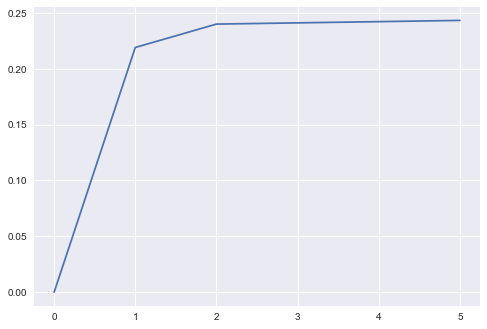

In [12]:
frac_data_check = np.copy(xx)
frac_fixed_influence = np.copy(yy)
plt.plot(frac_data_check,frac_fixed_influence)
plt.plot(frac_data_check,zz)
plt.plot(frac_data_check,frac_data_check)

In [9]:
zz

array([0.        , 0.21892189, 0.23982398, 0.24092409, 0.2420242 ,
       0.24312431])